# Entity Embedding - Working Example " House Prices"

**The purpose of this notebook is to demonstrate  the practical implementation of the so-called Entity Embedding  for Encoding Categorical Features for Training a Neural Network.**

## Loading Libraries

In [32]:
import os 
import matplotlib.pylab as plt
import pandas as pd

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential,Model
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")
%matplotlib inline

##  The Ames Iowa Housing Data. 

In [2]:
url = 'http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls'
# Load the file into a Pandas DataFrame
data_df = pd.read_excel(url)
print('DataFrame size:', data_df.shape)

DataFrame size: (2930, 82)


In [3]:
data_df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,...,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,...,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,...,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,...,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,...,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,...,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Sub-Feature Space

In [5]:
# For same of demonstration, the following features are selected. 
features = ['Neighborhood','Bldg Type','Year Built','Roof Matl','Sale Condition','Sale Type','House Style','Gr Liv Area']

# The aim is to predcit sale prices.
target = ['SalePrice']
data_df=data_df[features + target]
data_df['Year Built']= data_df['Year Built'].astype('object')

## Data Preparation



### *  ** Train/Val/Test Split**

In [6]:
X_train, y_train = data_df.iloc[:2000][features], data_df.iloc[:2000][target]
X_val, y_val = data_df.iloc[2000:2500][features], data_df.iloc[2000:2500][target]
X_test = data_df.iloc[2500:][features]

### *  ** Data Transformations**

In [9]:
scalar=StandardScaler()
scalar.fit(X_train['Gr Liv Area'].values.reshape(-1, 1))
X_train['Gr Liv Area']=scalar.transform(X_train['Gr Liv Area'].values.reshape(-1, 1)) 
X_val['Gr Liv Area']=scalar.transform(X_val['Gr Liv Area'].values.reshape(-1, 1)) 

scalar.fit(y_train)
y_train=scalar.transform(y_train)
y_val=scalar.transform(y_val)

### *  ** Check for Mising Values**

In [10]:
missing_df = data_df[features + target].isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(data_df[features + target].shape[0]-missing_df['missing values'])/data_df[features + target].shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,Neighborhood,0,100.0
1,Bldg Type,0,100.0
2,Year Built,0,100.0
3,Roof Matl,0,100.0
4,Sale Condition,0,100.0
5,Sale Type,0,100.0
6,House Style,0,100.0
7,Gr Liv Area,0,100.0
8,SalePrice,0,100.0


## *  **  Categorical Features Embedding Preparation**

### *  ** Categorical Features and  Cardinality**

In [11]:
embed_cols=[i for i in X_train.select_dtypes(include=['object'])]

for i in embed_cols:
    print(i,data_df[i].nunique())

Neighborhood 28
Bldg Type 5
Year Built 118
Roof Matl 8
Sale Condition 6
Sale Type 10
House Style 8


### *  ** Categorical Features To List Format**
One need to convert data to list format to match the network structure. 

The following function takes the list of categorical features, and prepare such lists for the NN input.

In [12]:
embed_cols=[i for i in X_train.select_dtypes(include=['object'])]

#converting data to list format to match the network structure
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test 

In [13]:
X_train.head()

,Neighborhood,Bldg Type,Year Built,Roof Matl,Sale Condition,Sale Type,House Style,Gr Liv Area
0,NAmes,1Fam,1960,CompShg,Normal,WD,1Story,0.315074
1,NAmes,1Fam,1961,CompShg,Normal,WD,1Story,-1.224202
2,NAmes,1Fam,1958,CompShg,Normal,WD,1Story,-0.347220
3,NAmes,1Fam,1968,CompShg,Normal,WD,1Story,1.234589
4,Gilbert,1Fam,1997,CompShg,Normal,WD,2Story,0.260389


### *  ** Embedding Dimension - Hyperparamter**
The choice of embedding dimension is optional, essentially it is a hyperparamter that one need to choose beforehand and investigate. One rule of thumb is to choose half of the cardinality of the categorical feature if that is is up to 50 in length. 


In [15]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
    vocab  = no_of_unique_cat+1
  
    print('Categorica Variable:', categorical_var,
        'Unique Categories:', no_of_unique_cat,
        'Embedding Size:', embedding_size,
        'Vocab:', vocab)

Categorica Variable: Neighborhood Unique Categories: 26 Embedding Size: 13 Vocab: 27
Categorica Variable: Bldg Type Unique Categories: 5 Embedding Size: 3 Vocab: 6
Categorica Variable: Year Built Unique Categories: 116 Embedding Size: 50 Vocab: 117
Categorica Variable: Roof Matl Unique Categories: 7 Embedding Size: 4 Vocab: 8
Categorica Variable: Sale Condition Unique Categories: 6 Embedding Size: 3 Vocab: 7
Categorica Variable: Sale Type Unique Categories: 9 Embedding Size: 5 Vocab: 10
Categorica Variable: House Style Unique Categories: 8 Embedding Size: 4 Vocab: 9


### *  ** Proper Naming of Categorical Features for Labelling NN Layers**

In [16]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    input_name= 'Input_' + categorical_var.replace(" ", "")
    print(input_name)

Input_Neighborhood
Input_BldgType
Input_YearBuilt
Input_RoofMatl
Input_SaleCondition
Input_SaleType
Input_HouseStyle


## *  ** Build Neural Network**




### *  ** Putting it Altogether**
Here we basically make the embeding layers one at a time and append, and at the end we concatenate it together with the numerical features.


In [21]:
input_models=[]
output_embeddings=[]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in X_train.select_dtypes(include=['object']):
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
    vocab  = no_of_unique_cat+1
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(vocab, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.
input_numeric = Input(shape=(len(X_train.select_dtypes(include=numerics).columns.tolist()),))
embedding_numeric = Dense(128)(input_numeric) 
input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)
output = Dense(1000, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.4)(output)
output = Dense(512, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.3)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mape'])

### *  ** The Network Architecture**


In [30]:
import pydot_ng as pydot

In [33]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_19 (

### *  ** Training**


In [0]:
X_train_list,X_val_list,X_test_list = preproc(X_train,X_val, X_test)

In [29]:
history  =  model.fit(X_train_list,y_train,validation_data=(X_val_list,y_val) , epochs =  1000 , batch_size = 512, verbose= 2)

Train on 2000 samples, validate on 500 samples
Epoch 1/1000
 - 3s - loss: 1.1215 - mean_squared_error: 1.1215 - mean_absolute_percentage_error: 298.4222 - val_loss: 0.8739 - val_mean_squared_error: 0.8739 - val_mean_absolute_percentage_error: 271.7353
Epoch 2/1000
 - 0s - loss: 0.8407 - mean_squared_error: 0.8407 - mean_absolute_percentage_error: 252.5188 - val_loss: 0.7464 - val_mean_squared_error: 0.7464 - val_mean_absolute_percentage_error: 212.1898
Epoch 3/1000
 - 0s - loss: 0.7640 - mean_squared_error: 0.7640 - mean_absolute_percentage_error: 200.1515 - val_loss: 0.7301 - val_mean_squared_error: 0.7301 - val_mean_absolute_percentage_error: 169.4000
Epoch 4/1000
 - 0s - loss: 0.7334 - mean_squared_error: 0.7334 - mean_absolute_percentage_error: 169.3617 - val_loss: 0.7189 - val_mean_squared_error: 0.7189 - val_mean_absolute_percentage_error: 145.0171
Epoch 5/1000
 - 0s - loss: 0.7077 - mean_squared_error: 0.7077 - mean_absolute_percentage_error: 146.4570 - val_loss: 0.6990 - val_me

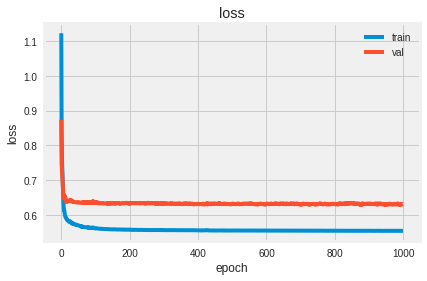

In [30]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

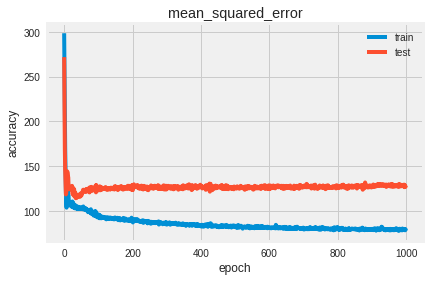

In [31]:
# summarize history for accuracy
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('mean_squared_error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()